# DataLoaderの作成
OpenPoseなどの姿勢推定で使うDatasetとDataLoaderを作成する

## 目標
1.	マスクデータについて理解する
2.	OpenPoseで使用するDatasetクラス、DataLoaderクラスを実装できるようになる
3.	OpenPoseの前処理およびデータオーギュメンテーションで、何をしているのか理解する

In [1]:
import json  # COCO.jsonに記載されている、姿勢推定に使う画像データのみを使用する
import os
import os.path as osp
import numpy as np
import cv2
from PIL import Image
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

import torch.utils.data as data   # DataLoader

In [2]:
def make_datapath_list(rootpath):
    """
    学習、検証の画像のデータとアノテーションデータ、マスクデータへのファイルパスリストを作成する
    """
    
    # アノテーションデータのjsonファイルを読み込む
    json_path = osp.join(rootpath, 'COCO.json')
    with open(json_path) as data_file:
        data_this = json.load(data_file)
        data_json = data_this['root']
        
        
    # indexを格納
    # train or valは、jsonデータの'dataset'か'isValidation'を見て判断
    num_samples = len(data_json)
    train_indexes = []
    val_indexes = []
    for count in range(num_samples):
        if data_json[count]['isValidation'] != 0.:
            val_indexes.append(count)
        else:
            train_indexes.append(count)
    
    # 画像ファイルパスを格納
    train_img_path = []
    val_img_path = []
    
    for idx in train_indexes:
        img_path = osp.join(rootpath, data_json[idx]['img_paths'])
        train_img_path.append(img_path)
    for idx in val_indexes:
        img_path = osp.join(rootpath, data_json[idx]['img_paths'])
        val_img_path.append(img_path)
    
    # マスクデータのパスを格納
    train_mask_path = []
    val_mask_path = []
    
    for idx in train_indexes:
        # "img_paths": "train2014/COCO_train2014_000000000036.jpg"  から 000000000036を取り出す　最後”じゃなくて$になっているのはなんでなんだろう
        img_idx = data_json[idx]['img_paths'][-16:-4]
        # anno_path = osp.join(rootpath, 'mask/train2014/mask_COCO_train2014_', img_idx, '.jpg')
        # 上だと./data/mask/train2014/mask_COCO_train2014_/000000000036/.jpgとなってしまって必要ないところに/がはいってしまう
        # anno_path = rootpath + 'mask/train2014/mask_COCO_train2014_' + img_idx + '.jpg'
        anno_path = './data/mask/train2014/mask_COCO_train2014_' + img_idx + '.jpg'
        train_mask_path.append(anno_path)
        
    for idx in val_indexes:
        img_path = osp.join(rootpath, data_json[idx]['img_paths'])
        # anno_path = osp.join(rootpath, 'mask/val2014/mask_COCO_val2014_', img_idx, '.jpg')
        # anno_path = rootpath + 'mask/val2014/mask_COCO_val2014_' + img_idx + '.jpg'
        anno_path =  './data/mask/val2014/mask_COCO_val2014_' + img_idx + '.jpg'
        val_mask_path.append(anno_path)
        
    # メタデータを格納
    train_meta_list = []
    val_meta_list = []
    
    for idx in train_indexes:
        train_meta_list.append(data_json[idx])
    for idx in val_indexes:
        val_meta_list.append(data_json[idx])
    
    print(type(anno_path))
    return train_img_path, val_img_path, train_mask_path, val_mask_path, train_meta_list, val_meta_list
    

In [3]:
# list(), [] の違いはあるのか？
a = list()
b = []
print(type(a))
print(a)
print(type(b))
print(b)
# 同じっぽい　　どっちで書いてもいい

<class 'list'>
[]
<class 'list'>
[]


In [4]:
a =  "train2014/COCO_train2014_000000000036.jpg"
a[-16:-4]

'000000000036'

In [8]:
# make_datapath_listの動作確認
train_img_list, val_img_list, train_mask_list, val_mask_list, train_meta_list, val_meta_list = make_datapath_list(rootpath='./data/')

<class 'str'>


In [9]:
print(train_img_path[0])
print(val_img_path[0])
print('----------------------------')
print(train_mask_path[0])
print(val_mask_path[0])
print('----------------------------')
print(train_meta_list[0])
print(val_meta_list[0])
# OK

./data/train2014/COCO_train2014_000000000036.jpg
./data/val2014/COCO_val2014_000000000136.jpg
----------------------------
./data/mask/train2014/mask_COCO_train2014_000000000036.jpg
./data/mask/val2014/mask_COCO_val2014_000000581899.jpg
----------------------------
{'dataset': 'COCO', 'isValidation': 0.0, 'img_paths': 'train2014/COCO_train2014_000000000036.jpg', 'img_width': 481.0, 'img_height': 640.0, 'objpos': [322.885, 395.485], 'image_id': 36.0, 'bbox': [167.58, 162.89, 310.61, 465.19], 'segment_area': 86145.297, 'num_keypoints': 13.0, 'joint_self': [[250.0, 244.0, 1.0], [265.0, 223.0, 1.0], [235.0, 235.0, 1.0], [309.0, 227.0, 1.0], [235.0, 253.0, 1.0], [355.0, 337.0, 1.0], [215.0, 342.0, 1.0], [407.0, 494.0, 1.0], [213.0, 520.0, 1.0], [445.0, 617.0, 1.0], [244.0, 447.0, 1.0], [338.0, 603.0, 1.0], [267.0, 608.0, 1.0], [0.0, 0.0, 2.0], [0.0, 0.0, 2.0], [0.0, 0.0, 2.0], [0.0, 0.0, 2.0]], 'scale_provided': 1.264, 'joint_others': [], 'annolist_index': 1.0, 'people_index': 1.0, 'numOthe

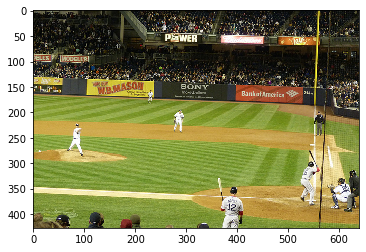

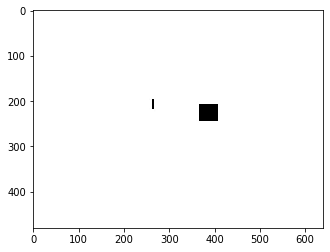

error: OpenCV(4.2.0) /Users/travis/build/skvark/opencv-python/opencv/modules/core/src/arithm.cpp:669: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'arithm_op'


In [11]:
# マスクデータの動きを確認
index = 410

# 画像
img = cv2.imread(val_img_list[index])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

# マスク
mask_miss = cv2.imread(val_mask_list[index])
mask_miss = cv2.cvtColor(mask_miss, cv2.COLOR_BGR2RGB)
plt.imshow(mask_miss)
plt.show()

# 合成
blend_img = cv2.addWeighted(img, 0.4, mask_miss, 0.6, 0)
plt.imshow(blend_img)
plt.show()

## 画像の前処理作成
Datatransformの作成 \
DatatransformをDatasetの中で使う

In [12]:
# データ処理のクラスとデータオーグメンテーションのクラスをimportする
from utils.data_augumentation import Compose, get_anno, add_neck, aug_scale, aug_rotate, aug_croppad, aug_flip, remove_illegal_joint, Normalize_Tensor, no_Normalize_Tensor

class DataTransfrom():
    """
    画像とマスク、アノテーション（メタデータ）の前処理クラス
    学習時と推論時でことなる動作をする
    学習時はdata augmentationする
    """
    
    def __init__(self):
        self.data_transform = {
            'train': Compose([
                get_anno(),
                add_neck(),
                aug_scale(),
                aug_rotate(),
                aug_croppad(),
                aug_flip(),
                remove_illegal_joint(),
                no_Normalize_Tensor()
            ]),
            'val': Compose([
                # 今回は省略
            ])
        }
        
    def __call__(self, phase, meta_data, img, mask_miss):
        """
        Parameters
        ----------------
        phase : 'train' or 'val'
            前処理のモードを指定
        meta_data, img, mask_miss　: make_datapath_list関数から作られたlistから各々読み込んだもの
        """
        meta_data, img, mask_miss = self.data_transform[phase](meta_data, img, mask_miss)
        
        return meta_data, img, mask_miss
    

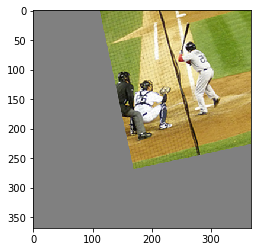

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


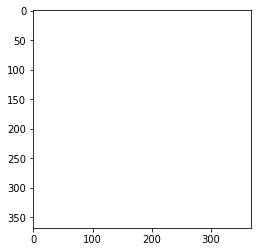

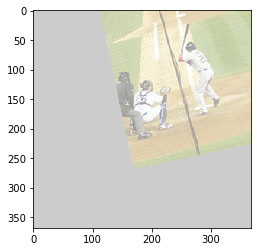

In [13]:
# 動作確認
idx = 410
img = cv2.imread(val_img_list[idx])
mask_miss = cv2.imread(val_mask_list[idx])
meta_data = val_meta_list[idx]

# 画像前処理
transform = DataTransfrom()
meta_data, img, mask_miss = transform('train', meta_data, img, mask_miss)

# 画像表示
img = img.numpy().transpose((1,2,0))
plt.imshow(img)
plt.show()

# マスク表示
mask_miss = mask_miss.numpy().transpose((1,2,0))
plt.imshow(mask_miss)
plt.show()

# 合成RGBに揃える
img = Image.fromarray(np.uint8(img*255))
img = np.asarray(img.convert('RGB'))
mask_miss = Image.fromarray(np.uint8(mask_miss))    # maskはなぜ*225しなくていいのだろうか？
mask_miss = np.asarray(mask_miss.convert('RGB'))
blend_img = cv2.addWeighted(img, 0.4, mask_miss, 0.6, 0)
plt.imshow(blend_img)
plt.show()

## 訓練データの正解情報として使うアノテーションデータの作成
アノテーション情報のピクセル座標（各関節の位置など）を中心としたガウス分布を作成し、確率として表すheatmapを作る

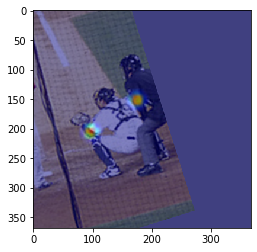

In [14]:
from utils.dataloader import get_ground_truth

# load image
# index = 24
img = cv2.imread(val_img_list[index])
mask_miss = cv2.imread(val_mask_list[index])
meta_data = val_meta_list[index]

# 画像前処理
transform = DataTransfrom()
meta_data, img, mask_miss = transform('train', meta_data, img, mask_miss)
img = img.numpy().transpose((1,2,0))
mask_miss = mask_miss.numpy().transpose((1,2,0))

# openposeのアノテーションデータ生成
heat_mask, heatmaps, paf_mask, pafs = get_ground_truth(meta_data, mask_miss)

# 左肘のheatmapを確認
# 元画像
img = Image.fromarray(np.uint8(img*255))
img = np.asarray(img.convert('RGB'))

# 左肘
heat_map = heatmaps[:,:,6]
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))  # ndarray -> Image(PIL)
heat_map = np.asarray(heat_map.convert('RGB'))
heat_map = cv2.resize(heat_map, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)  # 2次元画像にして4x4の近傍を利用するbi-cubic補完
# heatmapは画像サイズが1/8になっているので拡大する

# 合成して表示
blend_img = cv2.addWeighted(img, 0.5, heat_map, 0.5, 0)  # gamma : 全ての画素値に対して与えられる、切片みたいなもの
plt.imshow(blend_img)
plt.show()

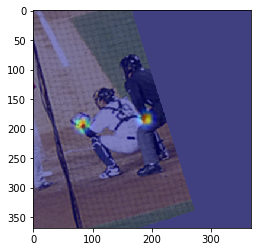

In [15]:
# 左手首
heat_map = heatmaps[:,:,7]
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))  # ndarray -> Image(PIL)
heat_map = np.asarray(heat_map.convert('RGB'))
heat_map = cv2.resize(heat_map, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)  # 2次元画像にして4x4の近傍を利用するbi-cubic補完
# heatmapは画像サイズが1/8になっているので拡大する

# 合成して表示
blend_img = cv2.addWeighted(img, 0.5, heat_map, 0.5, 0)  # gamma : 全ての画素値に対して与えられる、切片みたいなもの
plt.imshow(blend_img)
plt.show()

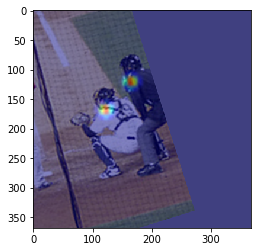

In [16]:
# 左肩
heat_map = heatmaps[:,:,5]
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))  # ndarray -> Image(PIL)
heat_map = np.asarray(heat_map.convert('RGB'))
heat_map = cv2.resize(heat_map, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)  # 2次元画像にして4x4の近傍を利用するbi-cubic補完
# heatmapは画像サイズが1/8になっているので拡大する

# 合成して表示
blend_img = cv2.addWeighted(img, 0.5, heat_map, 0.5, 0)  # gamma : 全ての画素値に対して与えられる、切片みたいなもの
plt.imshow(blend_img)
plt.show()

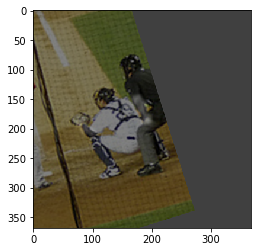

In [17]:
# 左手首と左肘へのPAFを確認
paf = pafs[:, :, 24]  
paf = Image.fromarray(np.uint8((paf)*255))
paf = np.asarray(paf.convert('RGB'))
paf = cv2.resize(paf, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)  # 2次元画像にして4x4の近傍を利用するbi-cubic補完
# pafは画像サイズが1/8になっているので拡大する

# 合成して表示
blend_img = cv2.addWeighted(img, 0.5, paf, 0.5, 0)  # gamma : 全ての画素値に対して与えられる、切片みたいなもの
plt.imshow(blend_img)
plt.show()

# 捕手の肘の位置がずれている
# これはアノテーションが悪いせい

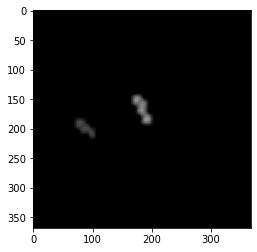

In [18]:
# pafのみを表示
paf = pafs[:,:,24]
paf = Image.fromarray(np.uint8((paf)*255))
paf = np.asarray(paf.convert('RGB'))
paf = cv2.resize(paf, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)  # 2次元画像にして4x4の近傍を利用するbi-cubic補完
plt.imshow(paf)
plt.show()

## Datasetの作成
前処理クラスDatatransformのインスタンスを使ってDatasetを作成する

In [25]:
from utils.dataloader import get_ground_truth

class COCOkeypointsDataset(data.Dataset):
    """
    MSCOCOのCocokeypointsのDatasetを作成するクラス
    PytorchのDatasetクラスを継承
    前処理をした画像とheatmapとpafがほしい
    
    Attributes
    ----------------
    img_list : 
        imgデータへのパスを格納したリスト
    mask_list : 
        maskデータへのパスを格納したリスト
    meta_list : list
        metaデータが格納されているリスト
    phase : 'train' or 'val'
        学習か検証かを設定
    transform : object
        前処理クラスのインスタンス
    """
    
    def __init__(self, img_list, mask_list, meta_list, phase, transform):
        self.img_list = img_list
        self.mask_list = mask_list
        self.meta_list = meta_list
        self.phase = phase
        self.transform = transform
        
    def __len__(self):
        """
        画像の枚数を返す
        """
        return len(self.img_list)
    
    def __getitem__(self, index):
        """
        オブジェクト（COCOkeypointsDatasetのインスタンス）に角括弧[]でアクセスしたときの挙動を設定する
        """
        img, heatmaps, heat_mask, pafs, paf_mask = self.pull_item(index)
        return img, heatmaps, heat_mask, pafs, paf_mask
    
    def pull_item(self, index):
        """
        Tensor形式の画像、ヒートマップ、ヒートマップのマクス、PAF、PAFのマスクを取得する
        """
        
        # 1. 画像読み込み
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path)    # 高さ、幅、色[BGR]
        
        # 2. マスクとメタデータの読み込み
        mask_miss = cv2.imread(self.mask_list[index])
        meta_data = self.meta_list[index]
        
        # 3. 画像前処理
        meta_data, img, mask_miss = self.transform(self.phase, meta_data, img, mask_miss)
        
        # 4. 正解アノテーションデータの取得
        mask_miss_numpy = mask_miss.numpy().transpose((1,2,0))  # この形にしておく必要がある
        heat_mask, heatmaps, paf_mask, pafs = get_ground_truth(meta_data, mask_miss_numpy)
        
        # 5. マスクデータはRGBが（１，１，１）か(0,0,0)なので次元を落とす
        # 3channelもいらないってこと
        # print('heat_mask before : ', heat_mask.size())　　torch.Size([46, 46, 19, 3])
        heat_mask = heat_mask[:,:,:,0]
        paf_mask = paf_mask[:,:,:,0]
        # print('heat_mask after : ', heat_mask.size())  torch.Size([46, 46, 19])
        
        # 6. チャネルが最後尾にあるので順番を変える
        # torch.Size([46, 46, 38]) -> torch.Size([38, 46, 46])
        paf_mask = paf_mask.permute(2,0,1)
        pafs = pafs.permute(2,0,1)
        heat_mask = heat_mask.permute(2,0,1)
        heatmaps = heatmaps.permute(2,0,1)
        
        return img, heatmaps, heat_mask, pafs, paf_mask

In [31]:
# Datasetの動作確認
# img_list, mask_list, meta_list の３つはmake_datapath_listで作成済み
# trainを使わないのは、今回valデータしかダウンロードしていないから
train_dataset = COCOkeypointsDataset(val_img_list, val_mask_list, val_meta_list, phase='train', transform=DataTransfrom())
val_dataset = COCOkeypointsDataset(val_img_list, val_mask_list, val_meta_list, phase='val', transform=DataTransfrom())

# データの取り出し例
item = train_dataset.__getitem__(3)
print(item[0].shape)  # img
print(item[1].shape)  # heatmaps
print(item[2].shape)  # heat_mask
print(item[3].shape)  # pafs
print(item[4].shape)  # paf_mask

torch.Size([3, 368, 368])
torch.Size([19, 46, 46])
torch.Size([19, 46, 46])
torch.Size([38, 46, 46])
torch.Size([38, 46, 46])


In [32]:
item = train_dataset[3]
print(item[0].shape)  # img
print(item[1].shape)  # heatmaps
print(item[2].shape)  # heat_mask
print(item[3].shape)  # pafs
print(item[4].shape)  # paf_mask

torch.Size([3, 368, 368])
torch.Size([19, 46, 46])
torch.Size([19, 46, 46])
torch.Size([38, 46, 46])
torch.Size([38, 46, 46])


## DataLoaderの作成

In [33]:
batch_size = 8

# trainとvalでdataset, batch size, shuffleを指定してDataLoaderインスタンスを作成
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {
    'train' : train_dataloader, 
    'val': val_dataloader
}

In [34]:
# DataLoaderの動作確認
batch_iterator = iter(dataloaders_dict['train'])  # イテレータに変換
item = next(batch_iterator)   # 1番目の要素を取り出す
print(item[0].shape)  # img
print(item[1].shape)  # heatmaps
print(item[2].shape)  # heat_mask
print(item[3].shape)  # pafs
print(item[4].shape)  # paf_mask

# batch_sizeが追加されたshapeになっている

torch.Size([8, 3, 368, 368])
torch.Size([8, 19, 46, 46])
torch.Size([8, 19, 46, 46])
torch.Size([8, 38, 46, 46])
torch.Size([8, 38, 46, 46])
